In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import * 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

path ="/home/ichanho/workspace/dogs-vs-cats/"

# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3

# 학습 데이터 준비 
filenames = os.listdir(path+"train")

categories=[]
for filename in filenames:
    category=filename.split(".")[0]
    if category =="dog":
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame(
    {"filename":filenames,
    "category":categories}
)        
df

,category,filename
0,0,cat.8971.jpg
1,0,cat.6075.jpg
2,1,dog.365.jpg
3,1,dog.7396.jpg
4,1,dog.7002.jpg
5,1,dog.6240.jpg
6,1,dog.11133.jpg
7,0,cat.217.jpg
8,1,dog.7659.jpg
9,1,dog.7302.jpg


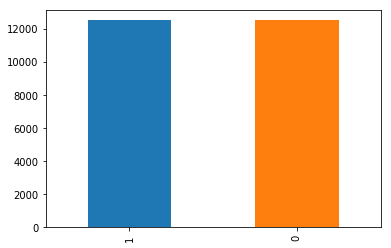

In [2]:
%matplotlib inline
df['category'].value_counts().plot.bar()

In [3]:
#from tf.keras.models import Sequential
#from tf.keras.layers import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [4]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어 2 
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [5]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [7]:
df['category']=df['category'].replace({0:'cat',1:"dog"})

In [8]:
train_df, validate_df = train_test_split(df , test_size=0.2, random_state= 42)

train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)


In [9]:
train_df['category'].value_counts()

dog    10053
cat     9947
Name: category, dtype: int64

In [10]:
validate_df['category'].value_counts()

cat    2553
dog    2447
Name: category, dtype: int64

In [11]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

# 트레이닝 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path+"train",
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )
    
validate_datagen=ImageDataGenerator(rescale=1./255)
# 검증이미지니까, 사진 그대로 쓰겠다. 

validation_generator=validate_datagen.flow_from_dataframe(
    validate_df,
    path+"train",
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
example_df=train_df.sample(n=1).reset_index(drop=True)
example_df

,category,filename
0,cat,cat.6619.jpg


In [13]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    path+"train",
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


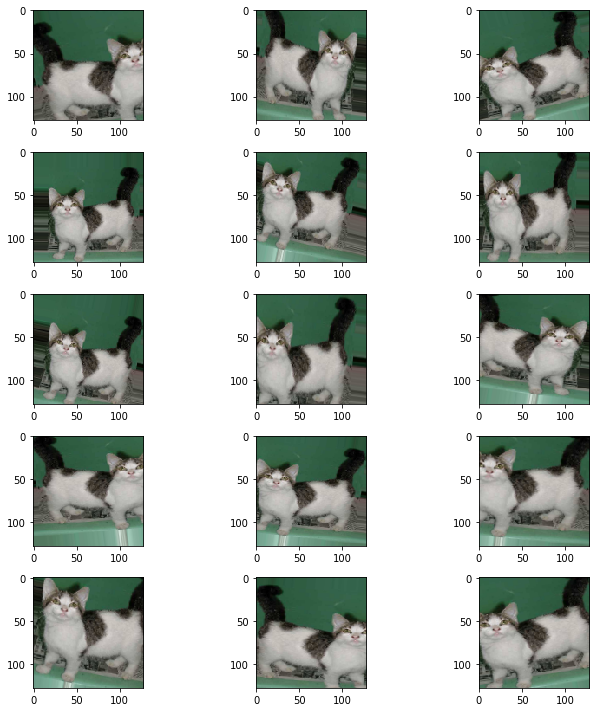

In [14]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [17]:
epochs = 100

history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    steps_per_epoch = total_train//batch_size ,
    validation_data=  validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks = callbacks,
)

# 모델 저장 
model.save_weights("model.h5")

Epoch 1/100
1333/1333 [==============================] - 192s 144ms/step - loss: 0.2570 - accuracy: 0.8912 - val_loss: 0.2018 - val_accuracy: 0.9239
Epoch 2/100
1333/1333 [==============================] - 187s 140ms/step - loss: 0.2529 - accuracy: 0.8954 - val_loss: 0.2133 - val_accuracy: 0.9157
Epoch 3/100
1333/1333 [==============================] - 188s 141ms/step - loss: 0.2507 - accuracy: 0.8969 - val_loss: 0.2183 - val_accuracy: 0.9141
Epoch 4/100
1333/1333 [==============================] - 187s 140ms/step - loss: 0.2549 - accuracy: 0.8954 - val_loss: 0.2074 - val_accuracy: 0.9183
Epoch 5/100
1333/1333 [==============================] - 187s 140ms/step - loss: 0.2541 - accuracy: 0.8944 - val_loss: 0.2196 - val_accuracy: 0.9155
Epoch 6/100
1333/1333 [==============================] - 186s 140ms/step - loss: 0.2530 - accuracy: 0.8957 - val_loss: 0.2389 - val_accuracy: 0.9073
Epoch 7/100
1333/1333 [==============================] - 188s 141ms/step - loss: 0.2450 - accuracy: 0.8970